# Image Classification Model Deployment

In this project I'll Make Image Classification Model and save it into tflite file that ready to be deployed.

##1. Download Dataset from Kaggle API

The dataset for this project is Animal Faces

This dataset, also known as Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512×512 resolution.
There are three domains of classes, each providing about 5000 images. By having multiple (three) domains and diverse images of various breeds per each domain, AFHQ sets a challenging image-to-image translation problem. The classes are:

- Cat;
- Dog;
- Wildlife.


Author:
@inproceedings{choi2020starganv2,

title={StarGAN v2: Diverse Image Synthesis for Multiple Domains},

author={Yunjey Choi and Youngjung Uh and Jaejun Yoo and Jung-Woo Ha},

booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},

year={2020}
}

The dataset is downloaded directly from Kaggle using Kaggle API an save it in ./content

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizki1994","key":"e2c181da4daa4a83ca5c75260be052ea"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/animal-faces

 99% 686M/696M [00:04<00:00, 98.1MB/s]
100% 696M/696M [00:04<00:00, 149MB/s] 


In [6]:
import os
import zipfile
local_zip = '/content/animal-faces.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

##2. Combine All the Data

Because the dataset already split to train and val folder. I'll combine all image from those folder into one, so i can fullfiled the requirement to split train and validation data 80% and 20%

In [7]:
import shutil

# Set the paths to your "test" and "val" folders
train_folder = "/content/afhq/train"
val_folder = "/content/afhq/val"

# Create a new folder to store the combined images
combined_folder = "/content/afhq/combined"
os.makedirs(combined_folder, exist_ok=True)

# Function to copy images from one folder to another
def copy_images(source_folder, destination_folder):
    for class_label in os.listdir(source_folder):
        source_class_path = os.path.join(source_folder, class_label)
        destination_class_path = os.path.join(destination_folder, class_label)

        # Create subfolder in the combined folder if it doesn't exist
        os.makedirs(destination_class_path, exist_ok=True)

        # Copy images from the source class subfolder to the destination
        for filename in os.listdir(source_class_path):
            source_path = os.path.join(source_class_path, filename)
            destination_path = os.path.join(destination_class_path, filename)
            shutil.copy(source_path, destination_path)


# Copy images from "test" folder to the combined folder
copy_images(train_folder, combined_folder)

# Copy images from "val" folder to the combined folder
copy_images(val_folder, combined_folder)

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
print('Total Images : ')
original_data = ImageDataGenerator(
    rescale=1./255).flow_from_directory(
    ('/content/afhq/combined'),
    target_size = (256,256),
    class_mode = 'categorical')

Total Images : 
Found 16130 images belonging to 3 classes.


In [10]:
a = original_data.class_indices
class_name = dict((v,k) for k,v in a.items())
class_name

{0: 'cat', 1: 'dog', 2: 'wild'}

##3. Print sample image

Before using the dataset, I'll print saample image from dataset.

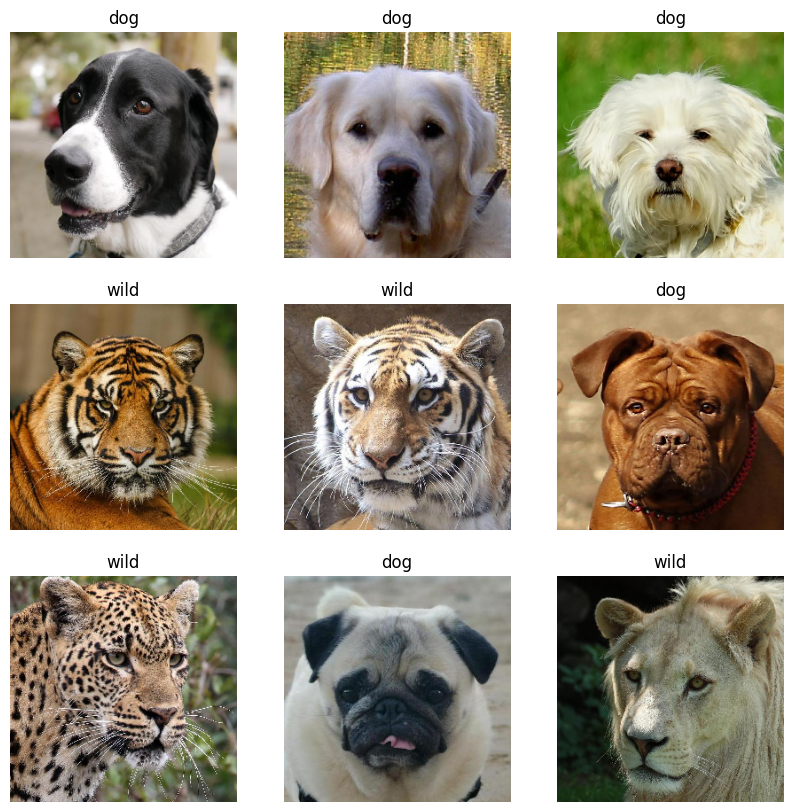

In [11]:
import numpy as np

plt.figure(figsize=(10, 10))
x,y= original_data.next()
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(x[i])
      plt.title(class_name[np.argmax(y[i])])
      plt.axis("off")

##4. Image Data Generator

Keras ImageDataGenerator class provides a quick and easy way to augment your images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more.

The major advantage of the Keras ImageDataGenerator class is its ability to produce real-time image augmentation. This simply means it can generate augmented images dynamically during the training of the model making the overall mode more robust and accurate.

In this datagenerator I'll split validation data 20% using validation_split=0.2

In [12]:
train_dir = os.path.join("/content/afhq/combined")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.2)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation')

Found 12906 images belonging to 3 classes.
Found 3224 images belonging to 3 classes.


##5. Callback Function

I'm using callback function to ensure the desired accuration and val_accuracy was achieved

In [14]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs:{}):
    if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
      print("\n Akurasi sudah di atas 97%, hentikan training!")
      self.model.stop_training = True

es = EarlyStopping(patience=4,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       pattience=2,
                       factor=0.5,
                       verbose=2)

##6. Model

Define Keras model with 5 Conv2D layers, with 5 MaxPooling 2D layers, 1 Flatten layers, 1 Dense hidden layers, 1 Dropout layers, and 1 dense output layers.

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0,5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

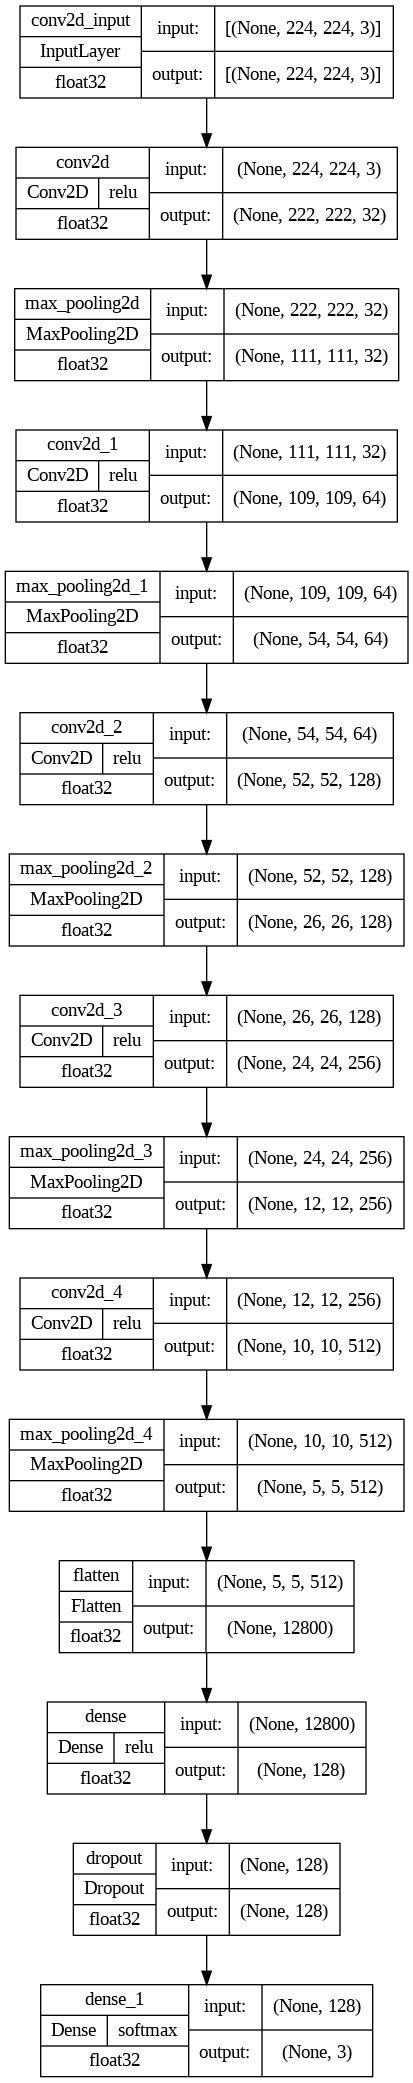

In [17]:
from tensorflow import keras

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True)

##7. Train the model

I'm training the model with 40 epochs, and call the callback function

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 64,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // 64,
    epochs = 40,
    verbose =2,
    callbacks=[es, lr, myCallback()]
)

Epoch 1/40
201/201 - 272s - loss: 0.6187 - accuracy: 0.7081 - val_loss: 0.3413 - val_accuracy: 0.8662 - lr: 0.0010 - 272s/epoch - 1s/step
Epoch 2/40
201/201 - 256s - loss: 0.1967 - accuracy: 0.9278 - val_loss: 0.1920 - val_accuracy: 0.9284 - lr: 0.0010 - 256s/epoch - 1s/step
Epoch 3/40
201/201 - 215s - loss: 0.1265 - accuracy: 0.9533 - val_loss: 0.2238 - val_accuracy: 0.9175 - lr: 0.0010 - 215s/epoch - 1s/step
Epoch 4/40

 Akurasi sudah di atas 97%, hentikan training!
201/201 - 215s - loss: 0.0899 - accuracy: 0.9673 - val_loss: 0.1140 - val_accuracy: 0.9613 - lr: 0.0010 - 215s/epoch - 1s/step


##8. Train and Validation Accuracy

In this section I visualize training and validation acccuracy with matplotlib

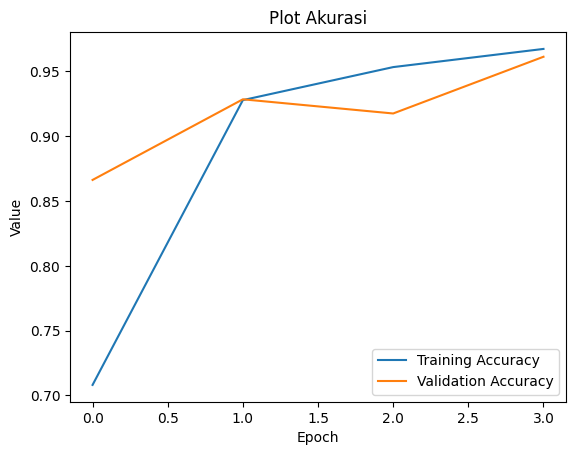

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Plot Akurasi')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

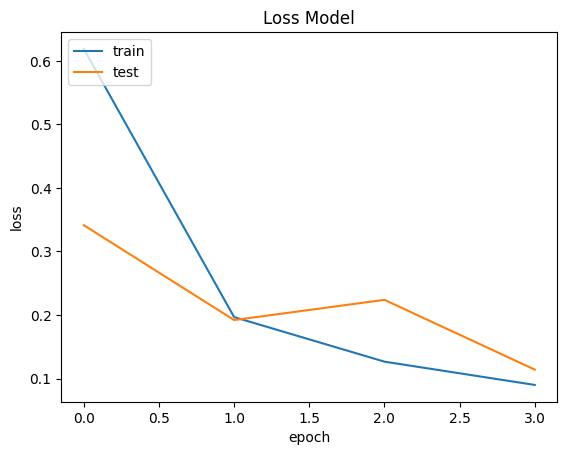

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##9. Save the model

The last step was save the model and convert it to tflite file

In [22]:
import pathlib
export_dir = '/content/saved_model'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('animal_faces.tflite')
tflite_model_file.write_bytes(tflite_model)

12835392